
## Prepare Download dataset

Load credential from drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make directory in local instance

In [2]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download dataset from kaggle

In [3]:
!kaggle datasets download sriramr/fruits-fresh-and-rotten-for-classification

 99% 3.55G/3.58G [00:22<00:00, 163MB/s]
100% 3.58G/3.58G [00:22<00:00, 168MB/s]


unzip dataset

In [4]:
!unzip -q /content/fruits-fresh-and-rotten-for-classification.zip

Import necessary library

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

check gpu used

In [21]:
!nvidia-smi

Mon May 16 03:28:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    28W /  70W |   4842MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

mapping directory

In [7]:
train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"

Add global variable

In [8]:
NUM_BATCH = 128
NUM_EPOCH = 10
SIZE_IMG = (150, 150)
DIM_IMG = (150, 150, 3)

Add Geneator and image augmentation

In [9]:
train_set = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode = 'nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)

val_set = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2,
)

In [30]:
train_data = train_set.flow_from_directory(
    train_dir, 
    target_size =SIZE_IMG,
    shuffle = True,
    class_mode='categorical',
    subset = 'training',
    batch_size=64,
    seed = 128,
)

val_data = val_set.flow_from_directory(
    train_dir, 
    target_size = SIZE_IMG,
    shuffle = True,
    class_mode='categorical',
    subset = 'validation',
    batch_size=64,
    seed = 128,
)

Found 8723 images belonging to 6 classes.
Found 2178 images belonging to 6 classes.


Load pre-trained model

In [32]:
input_dim = tf.keras.Input(shape=DIM_IMG)
Dense_121_mod = tf.keras.applications.DenseNet121(include_top = False,
                                                weights="imagenet",
                                                  # input_tensor=input_dim,
                                                  input_shape=DIM_IMG
                                                 )

In [34]:
Dense_121_mod.trainable = True

# set_trainable = False
# for layer in eff_b2_mod.layers:
#     if layer.name == 'multiply_16':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

In [45]:
tf.keras.backend.clear_session()

Menyusun neural network layer

In [46]:
from keras.layers import Flatten, Dense, Dropout,GlobalMaxPooling2D
from keras import regularizers

model = tf.keras.models.Sequential([
#                                     layers.Conv2D(64, (3,3), activation='relu', input_shape=(300, 300, 3)),
#                                     layers.MaxPooling2D(2,2),
#                                     layers.Conv2D(32, (3,3), activation='relu'),
#                                     layers.MaxPooling2D(2,2),
                                    Dense_121_mod,
                                    GlobalMaxPooling2D(),
                                    Dense(128, activation='relu',),
                                    Dropout(0.3),
                                    Dense(32, activation='relu',),
                                    Dropout(0.3),
                                    Dense(6, activation='softmax')

])
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, metrics=['accuracy'], loss=tf.keras.losses.CategoricalCrossentropy())

Membuat callback

In [13]:
class theCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.86):
            print("\n Akurasi mencapai target, stop training")
            self.model.stop_training = True

# Instantiate a callback object
callbacks = theCallback()

Summary and compile

In [47]:
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_max_pooling2d (Globa  (None, 1024)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [48]:
hist = model.fit(train_data, 
                 epochs=10, 
                 validation_data=val_data, 
                 steps_per_epoch=128, 
                #  callbacks=[callbacks]
                 )

Epoch 1/10
128/128 [==============================] - 104s 725ms/step - loss: 0.4071 - accuracy: 0.8860 - val_loss: 1.4085 - val_accuracy: 0.8104
Epoch 2/10
128/128 [==============================] - 91s 710ms/step - loss: 0.2409 - accuracy: 0.9338 - val_loss: 0.6765 - val_accuracy: 0.8604
Epoch 3/10
128/128 [==============================] - 90s 703ms/step - loss: 0.1885 - accuracy: 0.9476 - val_loss: 2.5202 - val_accuracy: 0.6717
Epoch 4/10
128/128 [==============================] - 90s 704ms/step - loss: 0.1621 - accuracy: 0.9558 - val_loss: 0.6776 - val_accuracy: 0.8453
Epoch 5/10
128/128 [==============================] - 97s 754ms/step - loss: 0.1457 - accuracy: 0.9595 - val_loss: 0.3179 - val_accuracy: 0.9178
Epoch 6/10
128/128 [==============================] - 90s 700ms/step - loss: 0.1246 - accuracy: 0.9651 - val_loss: 0.0683 - val_accuracy: 0.9738
Epoch 7/10
128/128 [==============================] - 90s 703ms/step - loss: 0.0710 - accuracy: 0.9815 - val_loss: 0.0681 - val_a

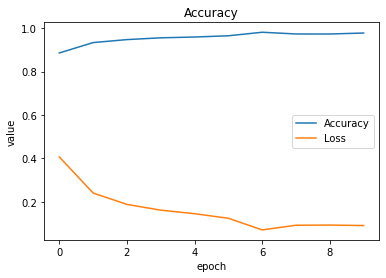

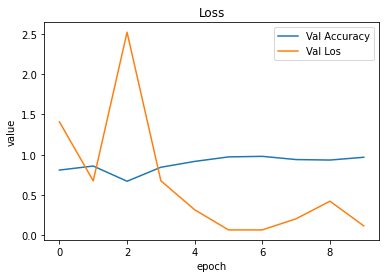

In [49]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'], label='Accuracy')
plt.plot(hist.history['loss'], label='Loss')
plt.title('Accuracy')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend()
plt.show()
# summarize history for loss
plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
plt.plot(hist.history['val_loss'], label='Val Los')
plt.title('Loss')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  y_classes = classes.argmax(axis=-1)
  print(y_classes)
  # if classes[0]>0.5:
  #   print(fn + " is a dog")
  # else:
  #   print(fn + " is a cat")

In [58]:
import numpy as np
from keras.preprocessing import image
np.loadtxt
classes = ['Fresh Apple','Fresh Banana','Fresh Orange','Rotten Apple','Rotten Banana','Rotten Orange']#creating the class labels
test_image = image.load_img('/content/dataset/test/rottenbanana/Screen Shot 2018-06-12 at 9.10.20 PM.png', target_size=(150,150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(np.argmax(result))
result=result[0]
for i in range(6):
    if result[i] == 1.:
        break;
prediction = classes[i]
print(prediction)

0
Fresh Apple
